In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.constants import M_sun, G, mu0
import astropy.units as u
import tqdm


sys.path.append('../my_funcs/')
from pipeline_main import pipeline
sys.path.append('../my_python_utilities')


# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

In [4]:
data = pipeline(snap = 710, run = 'my_core_13restart')
print(data.time)
data.recalc_L(verbose = 1); 

Initialising patch data


100%|██████████| 4165/4165 [00:03<00:00, 1269.08it/s]


21211.7281094472
Converged mean angular momentum vector after 0 iteration(s)


# Making the cut in cylindrical coordinates and also considering opening angle

In [5]:
height = 10; radius = 100
height /= data.au_length; radius /= data.au_length

patch_cartcoor = []
patch_values = []
for p in data.sn.patches:
    idx = np.nonzero((p.cyl_R < radius) & ((abs(p.cyl_z) < height) | (abs(p.cyl_z / p.cyl_R) < 0.3)))
    p.cyl_r[:-1]
    break


In [6]:
p.cyl_r[:,0,0,0]

array([ 0.05203948, -0.24720341, -0.60920823])

transpose(1, 2, 3, 0):

transpose is used to change the order of dimensions in your array.<br>
In this case, the numbers in the parentheses specify the new order of dimensions. It tells NumPy how to rearrange the axes.<br>
The original data had dimensions (2, 16, 16, 16), and we're reordering them as follows:<br>
1 becomes the new first axis (axis 0).<br>
2 becomes the new second axis (axis 1).<br>
3 becomes the new third axis (axis 2).<br>
0 becomes the new fourth axis (axis 3).<br>
This reordering aligns the (x, y) pairs as the first axis, which is what we want for our 2D array.<br>
reshape(-1, 2):
reshape is used to change the shape of an array, and you can specify the new shape using the arguments.<br>
In this case, we use -1 for the first dimension to let NumPy automatically compute the size of that dimension, given that we've specified the second dimension as 2.<br>
The -1 is a placeholder that tells NumPy to determine the size of that dimension based on the total number of elements in the array. This ensures that you don't have to manually calculate how many rows are needed; NumPy figures it out.<br>
The 2 in the second argument specifies that each row should contain two elements, corresponding to the (x, y) coordinates of your points.

In [7]:
for i in p.cyl_r[:-1].transpose(1, 2, 3, 0).reshape(-1, 2):
    if np.isclose(i[0], 0.05203948):
        print(i)

[ 0.05203948 -0.24720341]
[0.05203941 0.22223176]


In [8]:
height = 10; radius = 100
height /= data.au_length; radius /= data.au_length

# VERY IMPORTANT NOTE: After the transformation the first axis is the height
patch_cartcoor = []
patch_values = []
for p in tqdm.tqdm(data.sn.patches):
    idx = np.nonzero((p.cyl_R < radius) & ((abs(p.cyl_z) < height) | (abs(p.cyl_z / p.cyl_R) < 0.3)))
    patch_cartcoor.extend(p.cyl_r[1:, idx[0], idx[1], idx[2]].T.tolist())
    patch_values.extend(p.var('d')[idx[0], idx[1], idx[2]].tolist())
patch_cartcoor = np.asarray(patch_cartcoor)
patch_values = np.asarray(patch_values)

100%|██████████| 4165/4165 [00:01<00:00, 2461.37it/s]


In [9]:
np.shape(patch_cartcoor)

(927354, 2)

In [10]:
p.cyl_r[:-1, idx[0], idx[1], idx[2]].T.shape #.transpose(1, 2, 3, 0).reshape(-1, 2)

(0, 2)

In [11]:
box_length = 100 # [au]
Nr = 100**2
bins = np.linspace(-box_length//2, box_length//2, Nr) / data.au_length
interpol_to = np.hstack((bins[:,None], bins[:,None]), )
xx, yy = np.meshgrid(bins, bins, indexing = 'ij')

In [12]:
interpol_to.shape

(10000, 2)

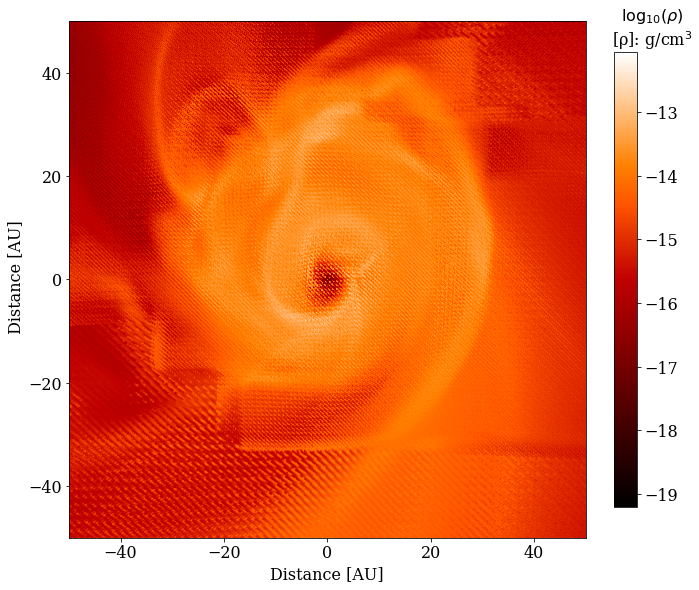

In [13]:
from scipy.interpolate import griddata

proj_data2 = griddata(patch_cartcoor, patch_values, xi = (xx, yy), method='linear') # Takes 15s

fig, axs = plt.subplots(figsize = (10,10))

cs = plt.imshow(np.log10(proj_data2 * data.cgs_density).T, extent=(-50, 50,-50, 50), cmap = 'gist_heat', origin='lower')
cbar = fig.colorbar(cs, ax = axs, fraction = 0.04);
cbar.set_label('$\log_{10}(ρ)$\n[ρ]: g/cm$^3$', labelpad = -25, y = 1.1, rotation = 0, fontsize = 16)
axs.set_xlabel(f'Distance [AU]', fontsize = 16); axs.set_ylabel(' Distance [AU]', fontsize = 16)
plt.tight_layout()


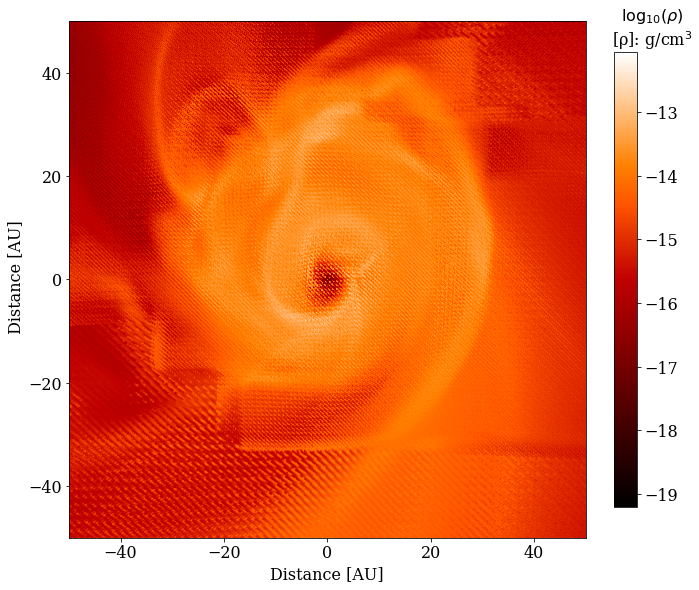

In [14]:
from scipy.interpolate import LinearNDInterpolator

proj_data2 = LinearNDInterpolator(patch_cartcoor, patch_values) # Takes 8s

Z = proj_data2(xx, yy) # Takes 7s

fig, axs = plt.subplots(figsize = (10,10))


cs = plt.imshow(np.log10(Z * data.cgs_density).T, extent=(-50, 50,-50, 50), cmap = 'gist_heat', origin='lower')
cbar = fig.colorbar(cs, ax = axs, fraction = 0.04);
cbar.set_label('$\log_{10}(ρ)$\n[ρ]: g/cm$^3$', labelpad = -25, y = 1.1, rotation = 0, fontsize = 16)
axs.set_xlabel(f'Distance [AU]', fontsize = 16); axs.set_ylabel(' Distance [AU]', fontsize = 16)
plt.tight_layout()
